In [1]:
%matplotlib notebook
# %matplotlib inline

import sys,os
import glob

from itertools import cycle
from itertools import combinations as comb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn.linear_model import LassoCV, ElasticNetCV, ElasticNet
from sklearn.preprocessing import scale, PolynomialFeatures

from scipy import io

from utils import read_design_space

import warnings

In [2]:
def normalize(values):
    return (values - values.min()) / (values.max() - values.min())

In [3]:
class MyLasso:
    
    def __init__(self,
                 poly=PolynomialFeatures(2, interaction_only=True), # Generate polynomial and interaction features
                 l1_ratio=1, # 0=Ridge, 1=LASSO
                 print_coefs=False,
                 plot_data=False,
                 n_jobs=1):
    
        self.poly = poly
        self.l1_ratio = l1_ratio
        self.n_jobs = n_jobs
        self.print_coefs = print_coefs
        self.plot_data = plot_data
    
    
    def run_lasso(self,
                  filename,
                  objective_idx, # Which column of y to use
                  poly=None,
                  l1_ratio=None,
                  n_jobs=None,
                  print_coefs=None,
                  plot_data=None
                 ):

        
        if poly is None:
            poly = self.poly
        if l1_ratio is None:
            l1_ratio = self.l1_ratio
        if n_jobs is None:
            n_jobs = self.n_jobs
        if print_coefs is None:
            print_coefs = self.print_coefs
        if plot_data is None:
            plot_data = self.plot_data
        
        X,y,yh,names,_ = read_design_space(filename, return_names=True)
        
#         names = None
        
        if names is None:
            names = np.array([ 'Knob' + str(i) for i in range(1,X.shape[1]+1)])
        else:
            for i,n in enumerate(names):
                if n.startswith("knob_"):
                    names[i] = "".join(n[5:].title().split("_"))
            names = names[:-y.shape[1]]

        names = np.array(names)
                    
    #     X+=1 # Remove zeros
        y = y[:,objective_idx]
        y = normalize(y)


        # Remove constant knobs
        non_constant_knobs = np.any(X != X[0,:], axis = 0)
        X = X[:,non_constant_knobs]
        names = names[non_constant_knobs]



        auto_scale = False

        if not auto_scale:
    #         Xstd = np.std(X, axis=0)
    #         X -= X.mean(axis=0)
    #         X /= Xstd

            X = scale(X, axis=0)

    #         Xnorm = np.linalg.norm(X, axis=0)
    #         X -= X.mean(axis=0)
    #         X /= Xnorm

            X[np.isinf(X)] = 0
            X[np.isnan(X)] = 0



        # Generate polynomial features from knobs
        X = poly.fit_transform(X)
        names = poly.get_feature_names(list(names))

    #     # Remove duplicates (?)
    #     _, uniqueX_idx = np.unique(X, axis=1, return_index=True)
    #     X = X[:,sorted(uniqueX_idx)]
    #     names = np.array(names)[sorted(uniqueX_idx)]
        names = np.array(names)


        # Compute LASSO

        eps = 1e-4  # the smaller it is the longer is the path
#         alpha_grid = np.logspace(np.log10(0.00001), np.log10(0.1), num=100)[::-1]
        alpha_grid = np.append(np.logspace(np.log10(0.00001), np.log10(1), num=100)[::-1], 0)
    #     alpha_grid = None

        # This computes the best alpha using cross-validation
        lasso = ElasticNetCV(l1_ratio=l1_ratio, eps=eps, alphas=alpha_grid, fit_intercept=auto_scale, cv=10, normalize=auto_scale,
                            n_jobs=n_jobs)
        lasso.fit(X, y)

        best_coefs = lasso.coef_


        # This computes all the alphas with all the data
        alphas_lasso, coefs_lasso, _ = lasso.path(X, y, l1_ratio=l1_ratio, alphas=lasso.alphas_, fit_intercept=auto_scale, normalize=auto_scale, n_jobs=n_jobs)



        mse = np.mean(lasso.mse_path_, axis=1)
        mse_std = np.std(lasso.mse_path_, axis=1)
        mse_min_idx = np.argmin(mse)

        best_coefs = coefs_lasso[:,mse_min_idx] # In theory, this is the same as lasso.coef_, but apparently not in practice


        # Sort and print coefficients (absolute values)

        sorted_coef_idx = np.argsort(np.abs(best_coefs))
        sorted_coefs = coefs_lasso[:,mse_min_idx][sorted_coef_idx]
        sorted_names = names[sorted_coef_idx]

        sorted_coefs_names = list(zip(sorted_coefs, sorted_names))

        if print_coefs:
            print("\n".join([str(c)+","+n for c,n in sorted_coefs_names if np.abs(c) > 0]))

        print("MSE " + str(np.min(mse)) + " std " + str(mse_std[mse_min_idx]) + "")


        # Plot results
        if plot_data:

            figure = plt.figure()
            ax1 = figure.add_subplot(3,1,1)
            ax2 = figure.add_subplot(3,1,2)
            # ax3 = figure.add_subplot(1,2,2)
            ax4 = figure.add_subplot(3,1,3)

            colors = cycle(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#00ff99','#b15928'])

            neg_log_alphas_lasso = -np.log10(alphas_lasso)

            for coef_l, c, n in zip(coefs_lasso, colors, names):
#                 l1 = ax1.plot(neg_log_alphas_lasso, coef_l, c=c, label=n)
                l1 = ax1.semilogx(alphas_lasso, coef_l, c=c, label=n)
#             ax1.axvline(neg_log_alphas_lasso[mse_min_idx], linestyle=":")
            ax1.axvline(alphas_lasso[mse_min_idx], linestyle=":")

#             ax1.set_xlabel('-log$_{10}$(alpha)')
            ax1.set_xlabel('Alpha')
            ax1.set_ylabel('Coefficients')
            ax1.set_title('LASSO Paths')
            # plt.legend((l1), ('Lasso'), loc='lower left')
            # plt.legend(loc='lower left')
            ax1.invert_xaxis()

            ax2.errorbar(alphas_lasso, mse, yerr=mse_std, # neg_log_alphas_lasso
                         elinewidth=1, ecolor='gray', capsize=2,
                         linestyle='', marker='o', markersize=2,
                         color='r', label='MSE with Error Bars')
            ax2.axvline(alphas_lasso[mse_min_idx], linestyle=":", label='Alpha at Min MSE') # neg_log_alphas_lasso
            ax2.set_title('Cross-validated MSE of LASSO paths')
#             ax2.set_xlabel('-log$_{10}$(alpha)')
            ax2.set_xscale('log')
            ax2.set_xlabel('Alpha')
            ax2.set_ylabel('MSE')
            ax2.set_ylim(ymin=0)
            ax2.legend()
            ax2.invert_xaxis()

            plt.tight_layout()


            if False:
                sorted_abs_coefs = np.array(sorted_abs_coefs)
                sorted_names = np.array(sorted_names)
                sorted_abs_coefs_positive = sorted_abs_coefs[sorted_abs_coefs>0]
                sorted_names_positive = sorted_names[sorted_abs_coefs>0]

                figure = plt.figure()
                ax3 = figure.add_subplot(1,1,1)
                ax3.bar(np.arange(len(sorted_abs_coefs_positive)), sorted_abs_coefs_positive, 0.95, color='#a6cee3')
                ax3.set_xticks(np.arange(len(sorted_abs_coefs_positive)))
                ax3.set_xticklabels(sorted_names_positive, rotation=90)


            if True:
                model = X.dot(best_coefs)
                y_sort_idx = np.argsort(y)

#                 figure = plt.figure()
#                 ax4 = figure.add_subplot(1,1,1)
                ax4.plot(y[y_sort_idx], label="Ground truth")
                ax4.plot(model[y_sort_idx], label="LASSO model")
                ax4.set_xlabel('Design # - Sorted by Objective')
                ax4.set_ylabel('Normalized\nObjective')
                ax4.legend()



            plt.show()


        return sorted_coefs_names



final_result_impl_hist.csv


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-pack

0.001721446053656883,NumHist PipeFactor
-0.023913151529244864,NumWorkItems
0.06908721782637389,PipeFactor
0.18005633229416831,NumWorkGroups
0.229302429410596,NumHist
0.4548310931406201,1
MSE 0.045094987321528404 std 0.024088625536064678


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Conv

<IPython.core.display.Javascript object>


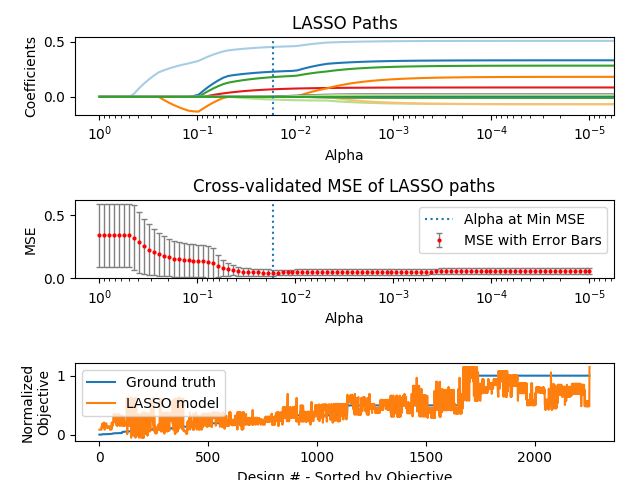

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to inc

-0.0031004766275857017,NumWorkItems
0.008574385758580272,NumHist UnrollFactor
0.017829925144170738,NumWorkGroups UnrollFactor
-0.024303923983220645,NumHist
-0.03206481299803744,UnrollFactor
-0.046787939973604586,NumWorkGroups
0.07584714570147355,1
MSE 0.009629976597876313 std 0.016641412401688798


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, ra

<IPython.core.display.Javascript object>


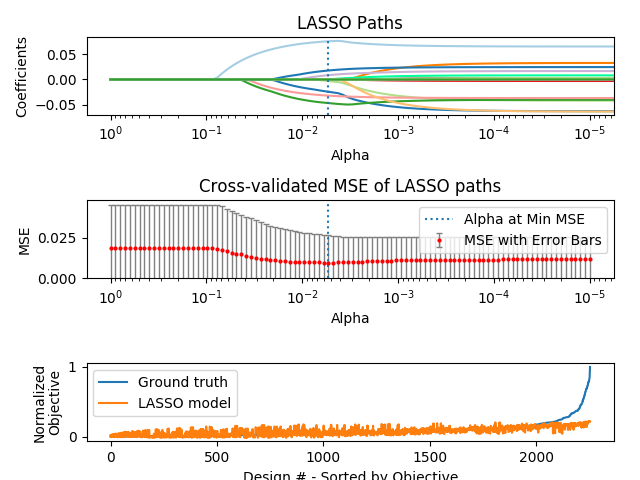

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


final_result_impl_dct.csv


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarni

0.0006215136009813365,BlockdimY UnrollDct
0.001032558630171803,BlockdimX BlockdimY
-0.0017018362823051072,UnrollWidth ArrayPartition
-0.002078830568768222,UnrollDct UnrollHeight
0.0023205741526420433,BlockdimX ArrayPartition
-0.0028996511391493926,BlockdimY UnrollHeight
-0.0035929077976702716,BlockdimY UnrollWidth
-0.004129950181604335,BlockdimY
-0.0051662097841493546,BlockdimX UnrollWidth
-0.006040625231238228,BlockdimX UnrollHeight
-0.006177326535479206,UnrollHeight ArrayPartition
-0.01217219129793091,BlockdimX
-0.01269650428068737,UnrollWidth UnrollHeight
0.01455284389280096,UnrollDct ArrayPartition
-0.019845901394728742,UnrollWidth
-0.02092259339925183,UnrollHeight
0.08902807048446669,ArrayPartition
0.12954522550215214,UnrollDct
0.38993110875362225,1
MSE 0.009080491986996045 std 0.000698300122244934


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)


<IPython.core.display.Javascript object>


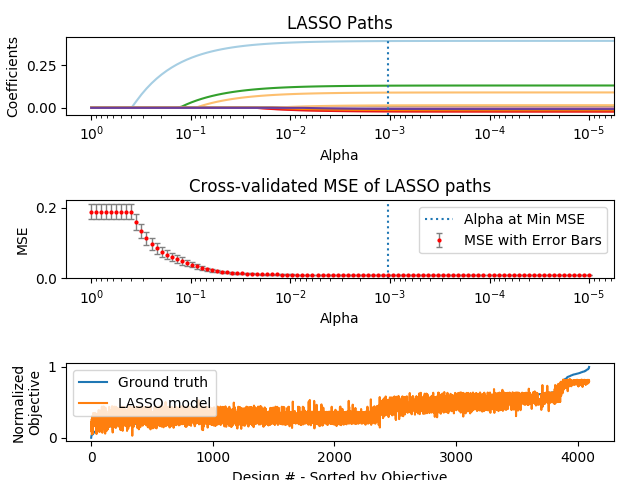

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected r

-0.0003688876181680604,BlockdimY UnrollHeight
0.0009116868655841235,BlockdimX UnrollHeight
-0.0014077142706050481,BlockdimY UnrollWidth
-0.0034178839645849827,BlockdimX UnrollWidth
0.003639789068456757,UnrollWidth UnrollHeight
0.006123298581686719,BlockdimX ArrayPartition
0.006629068985355573,BlockdimY ArrayPartition
0.0068151736324314986,BlockdimX UnrollDct
0.0072782459281015965,BlockdimX BlockdimY
0.008348081583505945,BlockdimY UnrollDct
0.00866511817485049,UnrollDct ArrayPartition
0.017754366556366658,UnrollWidth ArrayPartition
0.01825346051625456,UnrollHeight ArrayPartition
0.019944541578473515,UnrollDct UnrollWidth
0.02042897226377744,UnrollDct UnrollHeight
-0.027362537867522244,BlockdimX
-0.03645330712674917,BlockdimY
-0.049192357696963174,UnrollDct
-0.05018386665708254,ArrayPartition
-0.08420316303983277,UnrollWidth
-0.09115504139478946,UnrollHeight
0.28908519341927064,1
MSE 0.007570169302964542 std 0.0016307256437577548


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Conv

<IPython.core.display.Javascript object>


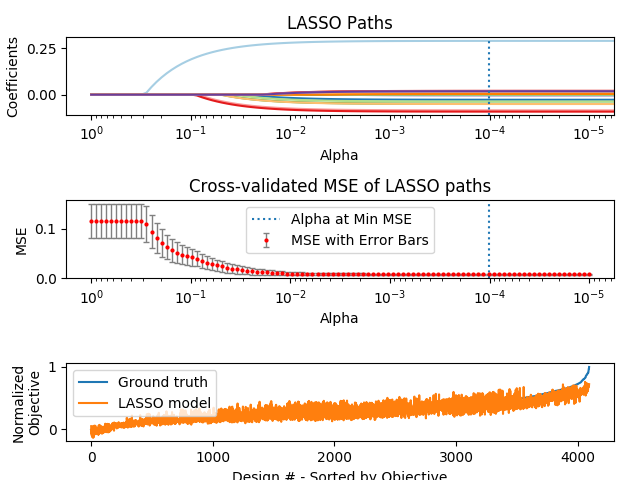

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


final_result_impl_matrixmul.csv


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-pack

-0.0032310797262544706,UnrollFactor1
-0.010923105402285324,SubdimX UnrollFactor2
-0.015220355682842461,SubdimX
0.026486993548978644,PartitionFactor
-0.02744319491456388,UnrollFactor2
0.7654645123779468,1
MSE 0.04394096992174036 std 0.016664722165386534


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)


<IPython.core.display.Javascript object>


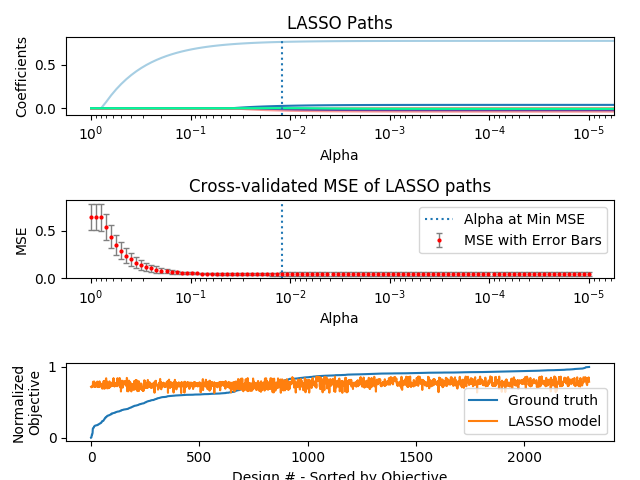

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected r

0.011025033756661758,PartitionFactor UnrollFactor2
0.013322822424938943,PartitionFactor SubdimX
0.015292813517704498,UnrollFactor1 UnrollFactor2
0.01680950128425775,SubdimX UnrollFactor1
0.022738295086323603,PartitionFactor UnrollFactor1
-0.02372421355666493,SubdimX UnrollFactor2
-0.053707009095016134,UnrollFactor2
-0.05599947059094902,SubdimX
-0.07470484456305913,PartitionFactor
-0.1109305733316675,UnrollFactor1
0.2308238365030767,1
MSE 0.0170028737480914 std 0.007302639796006976


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


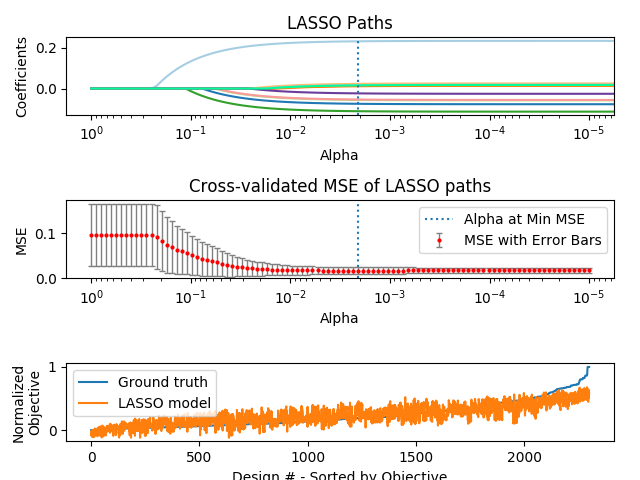

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


final_result_impl_sobelx.csv


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarni

-0.00023706319618857662,DimxPartitionFactor DimyPartitionFactor
-0.0006577372750217017,UnrollFactor
-0.00990787147801154,DimyPartitionFactor SubdimX
0.010695891373634336,DimxPartitionFactor UnrollFactor
-0.035015908485473805,DimyPartitionFactor
0.21120322313319093,SubdimX
0.2535396065658193,1
MSE 0.01538295405205437 std 0.009694185632614994


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


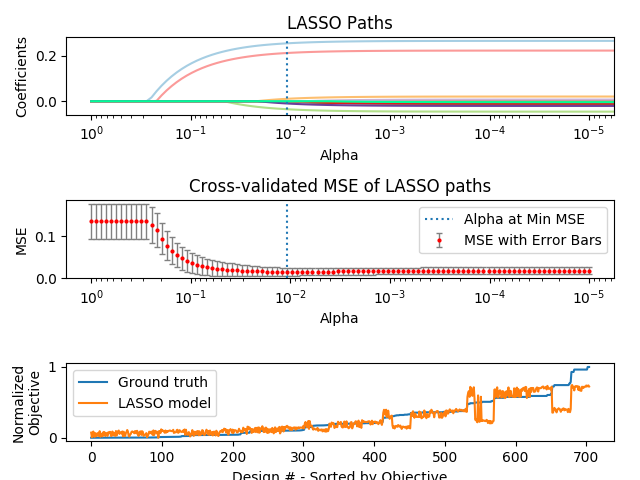

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected r

0.002403528536428616,DimxPartitionFactor SubdimX
0.003686228394356262,DimyPartitionFactor SubdimX
0.010169754156863772,UnrollFactor SubdimX
0.010579197276288487,DimxPartitionFactor UnrollFactor
0.011644186689849302,DimyPartitionFactor UnrollFactor
-0.013230136358124974,SubdimX
-0.01534922948359572,DimxPartitionFactor
-0.01868403672201671,DimyPartitionFactor
-0.06321150323258204,UnrollFactor
0.07695214252726475,1
MSE 0.005866712238942858 std 0.005024250293536035


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


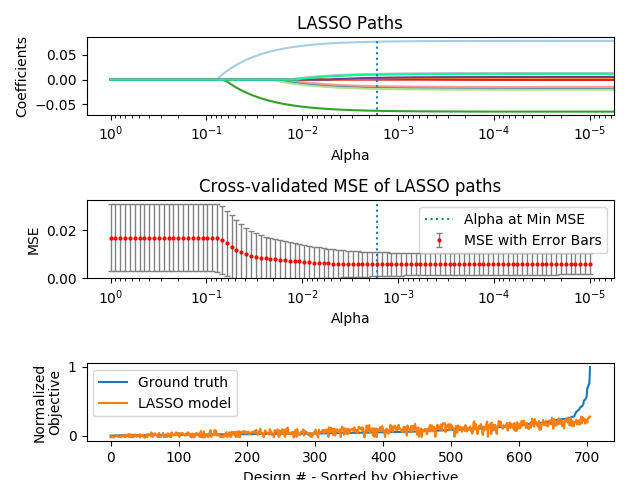

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


final_result_impl_sobely.csv


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-pack

0.013630451491878501,DimyPartitionFactor SubdimY
0.07876787259988641,DimxPartitionFactor SubdimY
0.1250725416659444,SubdimY
0.23518750133876445,1
MSE 0.03610864200374466 std 0.037951854462845935


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


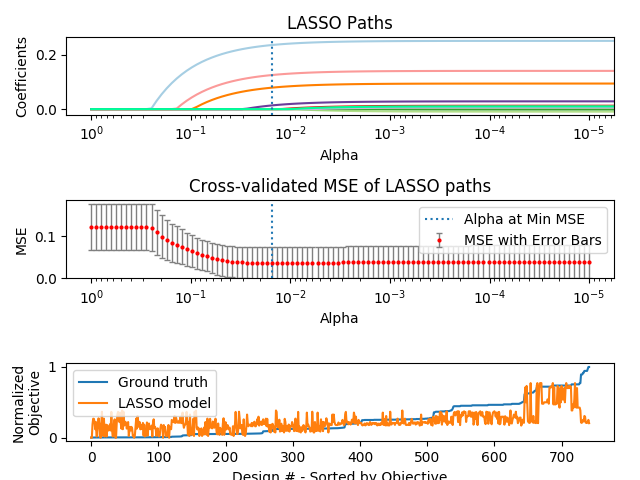

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to inc

0.0021648770542517376,DimyPartitionFactor SubdimY
0.0023887910536267497,DimxPartitionFactor SubdimY
0.0077587659167477055,DimyPartitionFactor UnrollFactor
0.009015314280988366,UnrollFactor SubdimY
-0.009998966539243568,DimyPartitionFactor
0.011098226142936068,DimxPartitionFactor UnrollFactor
-0.012052226243056694,SubdimY
-0.015213215517037389,DimxPartitionFactor
-0.05266138016338051,UnrollFactor
0.06251475436090917,1
MSE 0.004610944113819598 std 0.004866641004394233


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


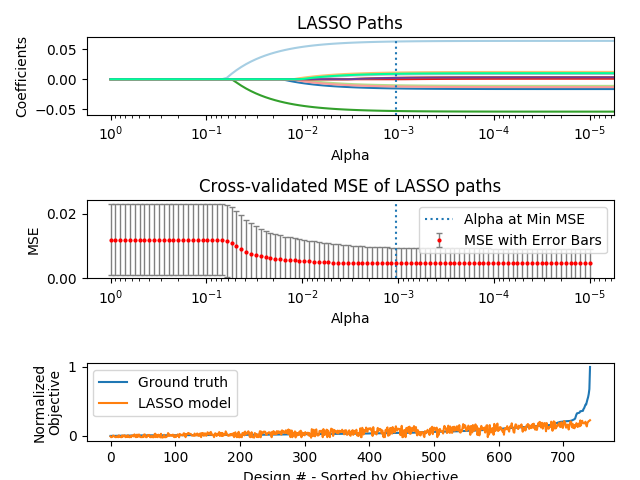

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


final_result_impl_tempmatch_unroll.csv


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-pack

0.06034471775953737,Tmpdim Indim
-0.06471521404843927,Tmpdim
-0.11926968186431837,Indim
0.12685797531395804,1
MSE 0.04261572173147201 std 0.07838024537633732


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>


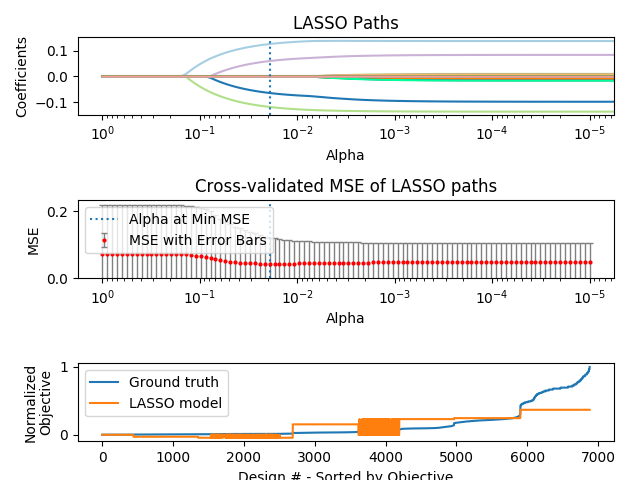

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to inc

0.004682698874805436,Tmpdim UnrollLoop3
-0.01797380497005316,UnrollLoop1
-0.01894197054075234,UnrollLoop3
0.030102790300599317,Tmpdim UnrollFactor
-0.0924134723898617,UnrollFactor
-0.10733369351386489,Tmpdim
0.18284920634347507,1
MSE 0.01294989052649639 std 0.008723001499003914


/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:474: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/home/siva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  Conv

<IPython.core.display.Javascript object>


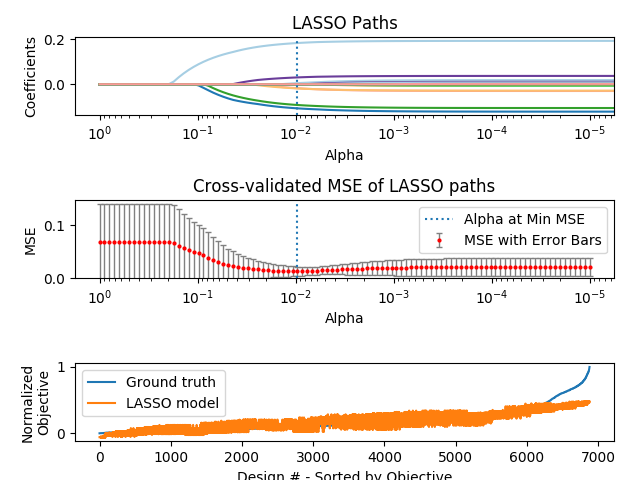

/home/siva/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: divide by zero encountered in log10
/home/siva/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


In [4]:
path = '/home/siva/Siva/RA/'
fns = [
    'final_result_impl_hist.csv',
    'final_result_impl_dct.csv',
    'final_result_impl_matrixmul.csv',
    'final_result_impl_sobelx.csv',
    'final_result_impl_sobely.csv',
    'final_result_impl_tempmatch_unroll.csv',
]

lasso = MyLasso(print_coefs=True,
                plot_data=True,
                poly=PolynomialFeatures(2, interaction_only=True),
                n_jobs=4)

for fn in fns:
    filename = path + fn
    
    print(fn)
    coefs = lasso.run_lasso(filename, 0)
    coefs = lasso.run_lasso(filename, 1)
